In [11]:
from dataset import transform
from dataset.shapenetcore import ShapeNetCore
import torch

# create an input transform with 50% points removed and 2% noise
input_transform = transform.RandomTransform(removal_amount=0, noise_amount=0.05, noise_type="gaussian", task="denoising")

# create the dataset (use 2048 for better visualization, but 1024 when training)
train_data = ShapeNetCore(
    root="Shapenetcore_benchmark",
    split="train",
    max_points=2048,
    input_transform=input_transform
)

In [12]:
from visualize import visualize_point_cloud_comparison

visualize_point_cloud_comparison(
    dataset=train_data,
    class_label="Airplane"
)

In [49]:
torch.get_rng_state()

tensor([187,  89, 195,  ...,   0,   0,   0], dtype=torch.uint8)

In [53]:
torch.seed()

3064258705167746337

In [103]:
# get name of top two models
# top_two_models = results_df.iloc[results_df["avg_chamf_dist"].sort_values().index]["model"][:2].tolist()
from visualize import visualize_point_cloud_comparison
from dataset import transform
from dataset.shapenetcore import ShapeNetCore
import torch

from pathlib import Path
from torch.utils.data import DataLoader
from models.completion import CompletionTransformer
from models.denoiser import DenoiserTransformer
from models.conv import DenoiserConv
import time
import torch
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# saved model paths
model_paths = list(Path("checkpoints").glob("completion_transformer_*.pth"))
# print saved model paths
print("Models saved to:")
for model_path in model_paths:
    print(model_path)
    
    
for checkpoint_name in model_paths:

    # skip poor performing models
    # if Path(checkpoint_name).stem not in top_two_models:
    #     continue

    # load checkpoint
    state_dict = torch.load(
        f=checkpoint_name, map_location=device
    )

    # create data transform
    input_transform = transform.RandomTransform(
        removal_amount=state_dict["removal_amount"],
        noise_amount=state_dict["noise_amount"],
        noise_type=state_dict["noise_type"],
        task="completion",
    )

    # load test data
    test_data = ShapeNetCore(
        root="./Shapenetcore_benchmark",
        split="test",
        max_points=state_dict["max_points"],
        input_transform=input_transform
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=1,
        shuffle=True,
        num_workers=1,
        pin_memory=True
    )

    # # instantiate model
    # model = DenoiserTransformer(
    #     num_layers=state_dict["num_layers"],
    #     num_heads=state_dict["num_heads"],
    #     d_model=state_dict["d_model"],
    #     # num_queries=int(state_dict["max_points"] * state_dict["removal_amount"])
    #     # use_pos_embeddings=state_dict["use_pos_embeddings"]
    # ).to(device).eval()
    
    model = CompletionTransformer(
        num_layers=state_dict["num_layers"],
        num_heads=state_dict["num_heads"],
        d_model=state_dict["d_model"],
        num_queries=int(state_dict["max_points"] * state_dict["removal_amount"])
        # use_pos_embeddings=state_dict["use_pos_embeddings"]
    ).to(device).eval()

    # necessary if distributed training was used
    if all(key.startswith("module.") for key in state_dict["model"].keys()):
        model = nn.DataParallel(model)

    # load weights
    model.load_state_dict(state_dict["model"])

    # visualize
    visualize_point_cloud_comparison(
        dataset=test_data,
        class_label="Earphone",
        model=model,
        title=Path(checkpoint_name).stem
    )
    time.sleep(0.2)

Models saved to:
checkpoints/completion_transformer_1.pth


/tmp/ipykernel_273702/581169441.py:33: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [3]:
import trimesh

# Load the .ply file
mesh = trimesh.load("synthetic_data/1381.ply")

# Visualize the mesh
mesh.show()


<trimesh.PointCloud(vertices.shape=(1024, 3), name=`1381.ply`)>


### Plot Training/Val Losses

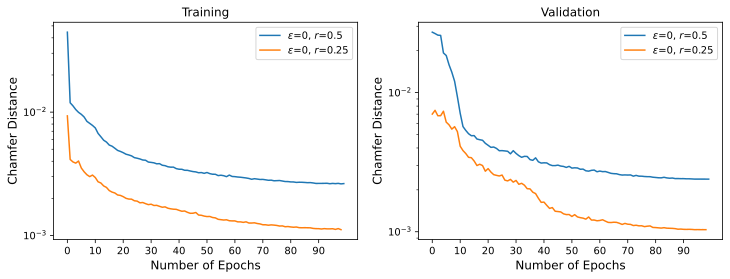

In [105]:
%config InlineBackend.figure_format = 'svg'
from pathlib import Path
from visualize import compare_train_val_losses

model_type = "completion_transformer"
model_paths = list(Path("checkpoints").glob(f"{model_type}_*.pth"))
compare_train_val_losses(model_paths)